# Описание проекта

Необходимо провести оценку результатов A/B-теста:

- Оценка корректности проведения теста,

- Анализ результатов теста.

В наличии:

1. датасет с действиями пользователей,

2. техническое задание,

3. несколько вспомогательных датасетов.

- Оцените корректность проведения теста
- Проанализируйте результаты теста

Чтобы оценить корректность проведения теста, необходимо проверить:

- пересечение тестовой аудитории с конкурирующим тестом,

- совпадение теста и маркетинговых событий, другие проблемы временных границ теста.


# Техническое задание


- Название теста: `recommender_system_test`;

- группы: А — контрольная, B — новая платёжная воронка;

- дата запуска: 2020-12-07;

- дата остановки набора новых пользователей: 2020-12-21;

- дата остановки: 2021-01-04;

- аудитория: 15% новых пользователей из региона EU;

- назначение теста: тестирование изменений, связанных с внедрением улучшенной рекомендательной системы;

- ожидаемое количество участников теста: 6000.

- ожидаемый эффект: за 14 дней с момента регистрации пользователи покажут улучшение каждой метрики не менее, чем на 10%:

    - конверсии в просмотр карточек товаров — событие `product_page`,
    
    - просмотры корзины — `product_cart`,
    
    - покупки — `purchase`.
    
    
# Описание данных



`ab_project_marketing_events.csv` — календарь маркетинговых событий на 2020 год.

Структура файла:

- `name` — название маркетингового события;

- `regions` — регионы, в которых будет проводиться рекламная кампания;

- `start_dt` — дата начала кампании;

- `finish_dt` — дата завершения кампании.

`final_ab_new_users.csv` — пользователи, зарегистрировавшиеся с 7 по 21 декабря 2020 года.

Структура файла:

- `user_id` — идентификатор пользователя;

- `first_date` — дата регистрации;

- `region` — регион пользователя;

- `device` — устройство, с которого происходила регистрация.

`final_ab_events.csv` — действия новых пользователей в период с 7 декабря 2020 по 4 января 2021 года.

Структура файла:

- `user_id` — идентификатор пользователя;

- `event_dt` — дата и время покупки;

- `event_name` — тип события;

- `details` — дополнительные данные о событии. Например, для покупок, `purchase,` в этом поле хранится стоимость покупки в долларах.

`final_ab_participants.csv` — таблица участников тестов.

Структура файла:

- `user_id` — идентификатор пользователя;

- `ab_test` — название теста;

- `group` — группа пользователя.


# Загрузка библиотек

In [1]:
import pandas as pd
import numpy as np
import datetime
from datetime import datetime, date, time
import plotly.express as px
import seaborn as sns
sns.set(rc={'figure.figsize':(10, 8)})
from plotly import graph_objects as go
import scipy.stats as stats
from scipy import stats as st
import math as mth
import matplotlib.pyplot as plt

# Первичное изучение файлов

In [2]:
pd.set_option('display.max_columns', None)
pd.options.display.float_format = '{:,.2f}'.format

In [3]:
events = pd.read_csv('/Users/andreygubanov/Desktop/Master thesis/2. AB test/final_ab_events.csv')

In [4]:
print('EVENTS')
display(events.head())
events.info()

EVENTS


,user_id,event_dt,event_name,details
0,E1BDDCE0DAFA2679,2020-12-07 20:22:03,purchase,99.99
1,7B6452F081F49504,2020-12-07 09:22:53,purchase,9.99
2,9CD9F34546DF254C,2020-12-07 12:59:29,purchase,4.99
3,96F27A054B191457,2020-12-07 04:02:40,purchase,4.99
4,1FD7660FDF94CA1F,2020-12-07 10:15:09,purchase,4.99


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440317 entries, 0 to 440316
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   user_id     440317 non-null  object 
 1   event_dt    440317 non-null  object 
 2   event_name  440317 non-null  object 
 3   details     62740 non-null   float64
dtypes: float64(1), object(3)
memory usage: 13.4+ MB


In [5]:
marketing_events = pd.read_csv('/Users/andreygubanov/Desktop/Master thesis/2. AB test/ab_project_marketing_events.csv')

In [6]:
print('MARKETING EVENTS')
display(marketing_events.head())
marketing_events.info()

MARKETING EVENTS


,name,regions,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03
1,St. Valentine's Day Giveaway,"EU, CIS, APAC, N.America",2020-02-14,2020-02-16
2,St. Patric's Day Promo,"EU, N.America",2020-03-17,2020-03-19
3,Easter Promo,"EU, CIS, APAC, N.America",2020-04-12,2020-04-19
4,4th of July Promo,N.America,2020-07-04,2020-07-11


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   name       14 non-null     object
 1   regions    14 non-null     object
 2   start_dt   14 non-null     object
 3   finish_dt  14 non-null     object
dtypes: object(4)
memory usage: 576.0+ bytes


In [7]:
new_users = pd.read_csv('/Users/andreygubanov/Desktop/Master thesis/2. AB test/final_ab_new_users.csv')

In [8]:
print('NEW USERS')
display(new_users.head())
new_users.info()

NEW USERS


,user_id,first_date,region,device
0,D72A72121175D8BE,2020-12-07,EU,PC
1,F1C668619DFE6E65,2020-12-07,N.America,Android
2,2E1BF1D4C37EA01F,2020-12-07,EU,PC
3,50734A22C0C63768,2020-12-07,EU,iPhone
4,E1BDDCE0DAFA2679,2020-12-07,N.America,iPhone


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61733 entries, 0 to 61732
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     61733 non-null  object
 1   first_date  61733 non-null  object
 2   region      61733 non-null  object
 3   device      61733 non-null  object
dtypes: object(4)
memory usage: 1.9+ MB


In [9]:
participants = pd.read_csv('/Users/andreygubanov/Desktop/Master thesis/2. AB test/final_ab_participants.csv')

In [10]:
print('PARTICIPANTS')
display(participants.head())
participants.info()

PARTICIPANTS


,user_id,group,ab_test
0,D1ABA3E2887B6A73,A,recommender_system_test
1,A7A3664BD6242119,A,recommender_system_test
2,DABC14FDDFADD29E,A,recommender_system_test
3,04988C5DF189632E,A,recommender_system_test
4,482F14783456D21B,B,recommender_system_test


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18268 entries, 0 to 18267
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  18268 non-null  object
 1   group    18268 non-null  object
 2   ab_test  18268 non-null  object
dtypes: object(3)
memory usage: 428.3+ KB


В таблицах содержатся данные типов object и float64.

Пропуски есть только в первом датасете.

Стоит отметить, что надо поменять формат столбцов с датой и временем.

### Дата и время

In [11]:
events['event_dt'] = pd.to_datetime(events['event_dt'], format='%Y-%m-%dT%H:%M:%S')
marketing_events['start_dt'] = pd.to_datetime(marketing_events['start_dt'], format='%Y-%m-%d')
marketing_events['finish_dt'] = pd.to_datetime(marketing_events['finish_dt'], format='%Y-%m-%d')
new_users['first_date'] = pd.to_datetime(new_users['first_date'], format='%Y-%m-%d')
events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440317 entries, 0 to 440316
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   user_id     440317 non-null  object        
 1   event_dt    440317 non-null  datetime64[ns]
 2   event_name  440317 non-null  object        
 3   details     62740 non-null   float64       
dtypes: datetime64[ns](1), float64(1), object(2)
memory usage: 13.4+ MB


In [12]:
marketing_events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   name       14 non-null     object        
 1   regions    14 non-null     object        
 2   start_dt   14 non-null     datetime64[ns]
 3   finish_dt  14 non-null     datetime64[ns]
dtypes: datetime64[ns](2), object(2)
memory usage: 576.0+ bytes


In [13]:
new_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61733 entries, 0 to 61732
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   user_id     61733 non-null  object        
 1   first_date  61733 non-null  datetime64[ns]
 2   region      61733 non-null  object        
 3   device      61733 non-null  object        
dtypes: datetime64[ns](1), object(3)
memory usage: 1.9+ MB


С датами разобрались.

### Дубликаты

In [14]:
marketing_events['name'].unique()

array(['Christmas&New Year Promo', "St. Valentine's Day Giveaway",
       "St. Patric's Day Promo", 'Easter Promo', '4th of July Promo',
       'Black Friday Ads Campaign', 'Chinese New Year Promo',
       'Labor day (May 1st) Ads Campaign',
       "International Women's Day Promo",
       'Victory Day CIS (May 9th) Event', 'CIS New Year Gift Lottery',
       'Dragon Boat Festival Giveaway', "Single's Day Gift Promo",
       'Chinese Moon Festival'], dtype=object)

In [15]:
marketing_events['name'].value_counts()

St. Valentine's Day Giveaway        1
Labor day (May 1st) Ads Campaign    1
Black Friday Ads Campaign           1
Easter Promo                        1
Single's Day Gift Promo             1
Christmas&New Year Promo            1
St. Patric's Day Promo              1
International Women's Day Promo     1
Chinese New Year Promo              1
CIS New Year Gift Lottery           1
4th of July Promo                   1
Victory Day CIS (May 9th) Event     1
Dragon Boat Festival Giveaway       1
Chinese Moon Festival               1
Name: name, dtype: int64

В колонке name дубликаты отсутствуют. 

Проверим regions.

In [16]:
marketing_events['regions'].unique()

array(['EU, N.America', 'EU, CIS, APAC, N.America', 'N.America', 'APAC',
       'EU, CIS, APAC', 'CIS'], dtype=object)

In [17]:
marketing_events['regions'].value_counts()

APAC                        4
EU, CIS, APAC, N.America    3
EU, N.America               2
EU, CIS, APAC               2
CIS                         2
N.America                   1
Name: regions, dtype: int64

В колонке regions также нет дубликатов.

In [18]:
marketing_events.duplicated().sum()

0

In [19]:
new_users.duplicated().sum()

0

In [20]:
new_users['region'].value_counts()

EU           46270
N.America     9155
CIS           3155
APAC          3153
Name: region, dtype: int64

In [21]:
new_users['device'].value_counts()

Android    27520
PC         15599
iPhone     12530
Mac         6084
Name: device, dtype: int64

Пока дубликатов нет, это хорошо.

In [22]:
participants.duplicated().sum()

0

In [23]:
participants['group'].value_counts()

A    9655
B    8613
Name: group, dtype: int64

In [24]:
participants['ab_test'].value_counts()

interface_eu_test          11567
recommender_system_test     6701
Name: ab_test, dtype: int64

Дубликаты в колонках group и ab_test отсутствуют.

Группы: 

- А (контрольная), 

- B (новая платежная воронка).

In [25]:
events['event_name'].value_counts()

login           189552
product_page    125563
purchase         62740
product_cart     62462
Name: event_name, dtype: int64

In [26]:
events.duplicated().sum()

0

Дубликатов тоже нет.

## Вывод

1. Все необходимые библиотеки загружены.

2. Произведен первичный анализ данных.

3. Форматы даты и времени приведены к удобному для работы.

4. Пропуски в датасете events в столбце details оставим, так как стоимость покупки может быть только у "purchase", в иных случаях это не представляется возможным, так как это либо ошибка, либо баг.

5. Во всех 4 предоставленных датасетах отсутствуют дубликаты.


# Исследовательский анализ данных

1) Изучим частоту событий в датасете.

2) Отсортируем события по частоте для удобства анализа.

In [27]:
count_event = events.groupby('event_name').agg({'user_id':'count'}).reset_index().sort_values(by='user_id', ascending=False)
count_event.rename(columns={'user_id': 'quantity_events'}, inplace=True)
display(count_event)

,event_name,quantity_events
0,login,189552
2,product_page,125563
3,purchase,62740
1,product_cart,62462


Интересно, некоторые пользователи делают заказ, не добавив товар в корзину. Так как на этом шаге транзакций меньше, чем на шаге "заказ".

Сделаем воронку по уникальным пользователям.

In [28]:
events_funnel = events.groupby('event_name').agg({'user_id':'nunique'}).reset_index().sort_values(by='user_id', ascending=False)
events_funnel.rename(columns={'user_id': 'quantity_events'}, inplace=True)
display(events_funnel)

,event_name,quantity_events
0,login,58697
2,product_page,38929
3,purchase,19569
1,product_cart,19284


Теперь посчитаем конверсию.

In [29]:
conversion_step2 = round(38929/58697*100)
conversion_step3 = round(19569/38929*100)
conversion_step4 = round(19284/19569*100)

print('Конверсия на product_page,%: {}'.format(conversion_step2))
print('Конверсия на purchase,%: {}'.format(conversion_step3))
print('Конверсия на product_cart, %: {}'.format(conversion_step4))

Конверсия на product_page,%: 66
Конверсия на purchase,%: 50
Конверсия на product_cart, %: 99


Сразу же стоит отметить, что порядок событий немного некорректен, как я отмечал выше. То есть, product_cart должен идти перед purchase. Пока это выглядит как баг системы, о котором надо сообщить или же, действительно, некоторые пользователи миновали этот этап.

Самые большие потери (50%) идут на 3 шаге. Лишь половина пользователей совершают покупку после просмотра страницы с товаром.

После регистрации 66% пользователей просматривают страницы с товаром. 

На втором этапе теряется 36% пользователей. 

На финальном этапе, теряется лишь 1%.

Посчитаем события и пользователей в датасете events, чтобы понять обладают ли выборки одинаковыми распределениями количества событий на пользователя.

In [30]:
event = len(events)
print('Всего событий в логе: {}'.format(event), 'шт.')

user = events['user_id'].nunique()
print('Всего уникальных пользователей в логе: {}'.format(user))

Всего событий в логе: 440317 шт.
Всего уникальных пользователей в логе: 58703


Посчитаем среднее.

In [31]:
mean = events.groupby('user_id')['event_name'].count().mean()
print('В среднем на одного пользователя приходится событий: {}'.format(mean))

median = events.groupby('user_id')['event_name'].count().median()
print('В среднем на одного пользователя приходится событий: {}'.format(median))

mode = events.groupby('user_id')['event_name'].count().mode()
print('В среднем на одного пользователя приходится событий: {}'.format(mode))

В среднем на одного пользователя приходится событий: 7.500758053251111
В среднем на одного пользователя приходится событий: 6.0
В среднем на одного пользователя приходится событий: 0    6
dtype: int64


На каждого пользователя в среднем приходится 6 событий.

Значение медианы и моды совпало.

Посмотрим на распределение событий:

In [32]:
events.groupby('user_id')['event_name'].count().describe()

count   58,703.00
mean         7.50
std          4.23
min          1.00
25%          4.00
50%          6.00
75%          9.00
max         36.00
Name: event_name, dtype: float64

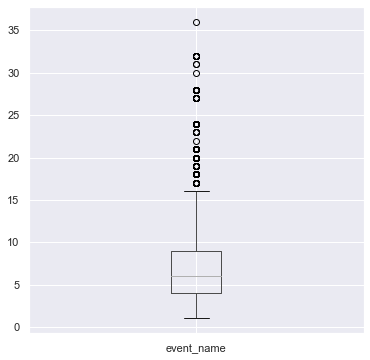

In [33]:
events_per_user = events.groupby('user_id')['event_name'].count().reset_index()
events_per_user.boxplot(column='event_name', figsize=(6,6))

#### Вывод:

1) на 25% пользователей приходится 4 события.

2) на 50% пользователей приходится до 6 событий.

3) на 75 % пользователей приходится до 9 событий.

4) выбросы начинаются от 16 до 36 событий на 1 пользователя.

Максимальный выброс - 36 событий на одного пользователя


#### Разберемся, присутствуют ли в выборках одни и теже пользователи или нет.

In [34]:
participants['user_id'].count()
print('Количество пользователей в выборках: {}'.format(event))

participants['user_id'].nunique()
print('Количество уникальных пользователей в выборках: {}'.format(event))

participants.groupby('user_id')['group'].nunique().describe()

Количество пользователей в выборках: 440317
Количество уникальных пользователей в выборках: 440317


count   16,666.00
mean         1.05
std          0.21
min          1.00
25%          1.00
50%          1.00
75%          1.00
max          2.00
Name: group, dtype: float64

В группах А и В могут быть одни и теже пользователи, то есть один пользователь может участвовать в 2 выборках.

Посмотрим на 5 случайных пользователей, которые могут быть в 2 выборках.

In [35]:
users_in_2_groups = participants.groupby('user_id').agg({'group':'nunique'})
users_in_2_groups = users_in_2_groups[users_in_2_groups['group'] == 2]
display(users_in_2_groups)

,group
user_id,
0082295A41A867B5,2
00E68F103C66C1F7,2
02313B9E82255F47,2
023D4A062F40F10B,2
040F6DD6E792D0AB,2
...,...
FEA0C585A53E7027,2
FEC0BCA6C323872F,2
FEE7040D7D2F2968,2


In [36]:
user_in_2_groups = ['0082295A41A867B5', '00E68F103C66C1F7', '02313B9E82255F47', '023D4A062F40F10B', '040F6DD6E792D0AB']
participants.query('user_id in @user_in_2_groups').groupby('user_id').head(10)

,user_id,group,ab_test
585,02313B9E82255F47,A,recommender_system_test
869,023D4A062F40F10B,B,recommender_system_test
1278,040F6DD6E792D0AB,A,recommender_system_test
4074,00E68F103C66C1F7,A,recommender_system_test
4768,0082295A41A867B5,A,recommender_system_test
13448,023D4A062F40F10B,A,interface_eu_test
14161,0082295A41A867B5,B,interface_eu_test
15494,040F6DD6E792D0AB,B,interface_eu_test
15562,00E68F103C66C1F7,B,interface_eu_test
18130,02313B9E82255F47,B,interface_eu_test


Всего 776 пользователей попадают в обе группе, но они участвовали в разных тестах, то есть пользователей, которые приняли бы участие в одном и том же тесте нет.

Нам интересен только "recommender_system_test". 

Проверю на всем датасете, есть ли пользователи, которые принимали участие в этом тесте и попали сразу в обе группы.

In [37]:
participants.query('ab_test == "recommender_system_test"').groupby('user_id')['group'].nunique().describe()

count   6,701.00
mean        1.00
std         0.00
min         1.00
25%         1.00
50%         1.00
75%         1.00
max         1.00
Name: group, dtype: float64

В "recommender_system_test" нет пользователей, которые приняли бы участие сразу в двух группах А и В.

Теперь взглянем на распределение по дням.

In [38]:
events['date'] = events.event_dt.dt.date
display(events.head(3))


display(events['date'].min())
display(events['date'].max())

,user_id,event_dt,event_name,details,date
0,E1BDDCE0DAFA2679,2020-12-07 20:22:03,purchase,99.99,2020-12-07
1,7B6452F081F49504,2020-12-07 09:22:53,purchase,9.99,2020-12-07
2,9CD9F34546DF254C,2020-12-07 12:59:29,purchase,4.99,2020-12-07


datetime.date(2020, 12, 7)

datetime.date(2020, 12, 30)

Интервал с 7 по 30 декабря 2020.

Text(0.5, 1.0, 'Гистограмма по дате и событиям')

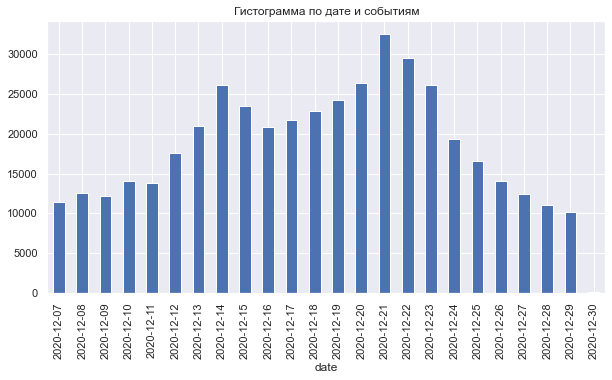

In [39]:
events.groupby('date')['event_name'].count().plot(kind='bar', grid=True, figsize=(10,5))
plt.title('Гистограмма по дате и событиям')

In [40]:
events.groupby('date')['event_name'].count().describe()

count       24.00
mean    18,346.54
std      7,493.48
min         89.00
25%     12,515.25
50%     18,516.50
75%     23,670.00
max     32,559.00
Name: event_name, dtype: float64

#### Вывод

1) Ежедневно в среднем происходит 18 516 событий. 

2) 30 декабря количество событий минимально.

3) Максимальное количество событий произошло 21 декабря. Потом идёт 22 декабря. 


Перейдём к нюансам, которые нужно учесть, прежде чем приступать к A/B-тестированию.

Я считаю, что нужно взглянуть на маркетинговый календарь и разобраться были ли события, которые могли повлиять на поведение потребителей.

In [41]:
display(marketing_events.head(10))

,name,regions,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03
1,St. Valentine's Day Giveaway,"EU, CIS, APAC, N.America",2020-02-14,2020-02-16
2,St. Patric's Day Promo,"EU, N.America",2020-03-17,2020-03-19
3,Easter Promo,"EU, CIS, APAC, N.America",2020-04-12,2020-04-19
4,4th of July Promo,N.America,2020-07-04,2020-07-11
5,Black Friday Ads Campaign,"EU, CIS, APAC, N.America",2020-11-26,2020-12-01
6,Chinese New Year Promo,APAC,2020-01-25,2020-02-07
7,Labor day (May 1st) Ads Campaign,"EU, CIS, APAC",2020-05-01,2020-05-03
8,International Women's Day Promo,"EU, CIS, APAC",2020-03-08,2020-03-10
9,Victory Day CIS (May 9th) Event,CIS,2020-05-09,2020-05-11


Берём период с 7 по 30 декабря 2020.

В последние 5 дней периода проходило маркетинговое событие "Christmas&New Year Promo". Регион - EU, N.America. Пересечение А/В теста с маркетинговыми активностями некорректно, это может повлиять на разультаты А/В теста. 

В последний день периода началось маркетинговое событие CIS New Year Gift Lottery. Так как это другой регион, то событие не влияет на разультаты А/В теста. 

Последняя проверка:

In [42]:
participants.query('ab_test == "recommender_system_test"').groupby('group')['user_id'].nunique()

group
A    3824
B    2877
Name: user_id, dtype: int64

В тесте "recommender_system_test" присутствуют пользователи обеих групп.

В группе В на 947 пользователей меньше, чем в группе А, что составляет примерно 25%.

# Оценка А/В-теста

Для оценки результатов создадим сводную таблицу со следующими данными:

1) только новые пользователи из региона EU

2) только пользователи, принявшие участие в recommender_system_test

3) информация к какой группе относится пользователь ( А/В) события.

In [43]:
new_users_EU = new_users[new_users['region'] == "EU"]
display(new_users_EU.head())

,user_id,first_date,region,device
0,D72A72121175D8BE,2020-12-07,EU,PC
2,2E1BF1D4C37EA01F,2020-12-07,EU,PC
3,50734A22C0C63768,2020-12-07,EU,iPhone
7,8942E64218C9A1ED,2020-12-07,EU,PC
9,FFCEA1179C253104,2020-12-07,EU,Android


In [44]:
participants_RST = participants[participants['ab_test'] == "recommender_system_test"]
display(participants_RST.head())

,user_id,group,ab_test
0,D1ABA3E2887B6A73,A,recommender_system_test
1,A7A3664BD6242119,A,recommender_system_test
2,DABC14FDDFADD29E,A,recommender_system_test
3,04988C5DF189632E,A,recommender_system_test
4,482F14783456D21B,B,recommender_system_test


In [45]:
ab_pivot = new_users_EU.merge(participants_RST, on='user_id', how='left') 
display(ab_pivot.head())

,user_id,first_date,region,device,group,ab_test
0,D72A72121175D8BE,2020-12-07,EU,PC,A,recommender_system_test
1,2E1BF1D4C37EA01F,2020-12-07,EU,PC,NaN,NaN
2,50734A22C0C63768,2020-12-07,EU,iPhone,NaN,NaN
3,8942E64218C9A1ED,2020-12-07,EU,PC,NaN,NaN
4,FFCEA1179C253104,2020-12-07,EU,Android,NaN,NaN


В сводной есть пропуски, убираю. Они появились из-за того, что там появились новые пользователи из EU, которые не принимали участия в тесте.

In [46]:
ab_pivot.dropna()

,user_id,first_date,region,device,group,ab_test
0,D72A72121175D8BE,2020-12-07,EU,PC,A,recommender_system_test
7,E6DE857AFBDC6102,2020-12-07,EU,PC,B,recommender_system_test
13,DD4352CDCF8C3D57,2020-12-07,EU,Android,B,recommender_system_test
16,831887FE7F2D6CBA,2020-12-07,EU,Android,A,recommender_system_test
28,4CB179C7F847320B,2020-12-07,EU,iPhone,B,recommender_system_test
...,...,...,...,...,...,...
46231,A09DFE27D4CFF8E8,2020-12-20,EU,Android,B,recommender_system_test
46238,0F7D49FC184EDCDE,2020-12-20,EU,PC,A,recommender_system_test
46249,574ACBC674BC385D,2020-12-20,EU,Mac,A,recommender_system_test
46250,0416B34D35C8C8B8,2020-12-20,EU,Android,A,recommender_system_test


In [47]:
final_df = ab_pivot.merge(events, on='user_id', how='left')
display(final_df.head())

,user_id,first_date,region,device,group,ab_test,event_dt,event_name,details,date
0,D72A72121175D8BE,2020-12-07,EU,PC,A,recommender_system_test,2020-12-07 21:52:10,product_page,nan,2020-12-07
1,D72A72121175D8BE,2020-12-07,EU,PC,A,recommender_system_test,2020-12-07 21:52:07,login,nan,2020-12-07
2,2E1BF1D4C37EA01F,2020-12-07,EU,PC,NaN,NaN,2020-12-07 09:05:47,product_cart,nan,2020-12-07
3,2E1BF1D4C37EA01F,2020-12-07,EU,PC,NaN,NaN,2020-12-10 04:13:53,product_cart,nan,2020-12-10
4,2E1BF1D4C37EA01F,2020-12-07,EU,PC,NaN,NaN,2020-12-12 17:54:57,product_cart,nan,2020-12-12


In [48]:
final_df.dropna(subset = ['group', 'ab_test', 'event_dt', 'event_name', 'date'], inplace = True)
final_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23420 entries, 0 to 329849
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   user_id     23420 non-null  object        
 1   first_date  23420 non-null  datetime64[ns]
 2   region      23420 non-null  object        
 3   device      23420 non-null  object        
 4   group       23420 non-null  object        
 5   ab_test     23420 non-null  object        
 6   event_dt    23420 non-null  datetime64[ns]
 7   event_name  23420 non-null  object        
 8   details     3196 non-null   float64       
 9   date        23420 non-null  object        
dtypes: datetime64[ns](2), float64(1), object(7)
memory usage: 2.0+ MB


In [49]:
final_df.duplicated().sum()

0

Создадим таблицу, в которой будет посчитано для всех групп число пользователей, совершивших каждое событие

In [50]:
groups = final_df.pivot_table(values='user_id', index='group', columns='event_name', aggfunc='nunique')
display(groups)

event_name,login,product_cart,product_page,purchase
group,,,,
A,2604,782,1685,833
B,877,244,493,249


Приступаем к проверке гипотез.

Я считаю, что у нас есть две гипотезы:

1) Нулевая гипотеза H0 - между долями нет значимой разница

2) Альтернативная гипотеза Н1 - между долями есть значимая разница

##### Конверсия в просмотр карточек товаров

In [51]:
alpha = .05
successes = np.array([1685, 493])
trials = np.array([2604, 877])
p1 = successes[0]/trials[0]
p2 = successes[1]/trials[1]
p_combined = (successes[0] + successes[1]) / (trials[0] + trials[1])
difference = p1 - p2
z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/trials[0] + 1/trials[1]))
distr = st.norm(0, 1)
p_value = (1 - distr.cdf(abs(z_value))) * 2
print('p-значение: ', p_value)
if (p_value < alpha):
    print("Отвергаем нулевую гипотезу: между долями есть значимая разница")
else:
    print("Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными")

p-значение:  6.942739359416805e-06
Отвергаем нулевую гипотезу: между долями есть значимая разница


В конверсии в просмотр карточек товаров в двух группах между долями есть значимая разница.

В группе А конверсия выше по сравнению с группой В.

##### Конверсия в покупках

In [52]:
alpha = .05
successes = np.array([833, 249])
trials = np.array([2604, 877])
p1 = successes[0]/trials[0]
p2 = successes[1]/trials[1]
p_combined = (successes[0] + successes[1]) / (trials[0] + trials[1])
difference = p1 - p2
z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/trials[0] + 1/trials[1]))
distr = st.norm(0, 1)
p_value = (1 - distr.cdf(abs(z_value))) * 2
print('p-значение: ', p_value)
if (p_value < alpha):
    print("Отвергаем нулевую гипотезу: между долями есть значимая разница")
else:
    print("Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными")

p-значение:  0.04652482738393027
Отвергаем нулевую гипотезу: между долями есть значимая разница


В конверсии в покупки в двух группах между долями есть значимая разница.

В группе А конверсия выше по сравнению с группой В.

##### Конверсия в добавление в корзину товаров

In [53]:
alpha = .05
successes = np.array([782, 244])
trials = np.array([2604, 877])
p1 = successes[0]/trials[0]
p2 = successes[1]/trials[1]
p_combined = (successes[0] + successes[1]) / (trials[0] + trials[1])
difference = p1 - p2
z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/trials[0] + 1/trials[1]))
distr = st.norm(0, 1)
p_value = (1 - distr.cdf(abs(z_value))) * 2
print('p-значение: ', p_value)
if (p_value < alpha):
    print("Отвергаем нулевую гипотезу: между долями есть значимая разница")
else:
    print("Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными")

p-значение:  0.21469192029582396
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


В конверсии добавления в корзину товаров в двух группах между долями нет значимой разницы.

# Ключевые выводы 

1) В последние 5 дней теста проходило маркетинговое событие "Christmas&New Year Promo" в Европе и Северной Америке. Это могло оказать существенное влияние на результаты теста, так как проведение теста и маркетинговых активностей параллельно может привести к искажению результатов теста.

2) Воронка, отсортированная по частоте:

- login - 58697 пользователя

- product_page - 38929 пользователя

- purchase - 19569 пользователя

- product_cart - 19284 пользователя.


3) Больше всего теряется пользователей на этапе покупки/добавлении в корзину.

4) На большинство пользователей приходится в среднем от 4 до 9 событий.

5) 776 пользователей оказались одновременно в 2 группах, но пользователей, которые бы приняли участия в тестах, находясь одновременно в 2 группах нет.

6) Число событий распределено по дням не равномерно. Ежедневно в среднем происходит 18 516 событий, максимальное количество событий произошло 21 декабря.

7) Оценка результатов A/B-тестирования показала, что ожидаемый результат не подтвердился. Тестовая группа В не показала лучшую конверсию по сравнению с контрольной группой А.